https://github.com/stefanogiagu/corso_AML_2022/blob/main/notebooks/es3/AML_2022_HandsOn_3_SimCLR_CNN_v1.1_SM.ipynb
<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2022/blob/main/notebooks/es3/AML_2022_3_SimCLR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning for Physics 2021-2022
## Hands-on session 3

Implementation in pytorch of a CNN+MLP for the self-supervised contrastive learning with SimCLR task of leranign useful representations of QCD hadronic jets from single quark/gluons and merged jest from boosted decays of W bosons.

At the extreme energies of the Large Hadron Collider, massive particles can be produced with such high Lorentz boost that their decays into hadrons (hadron jets) are collimated in such a way that the resulting particles overlap. Deducing whether the substructure of an observed jet is due to a single low-mass particle or to multiple decay objects of a high-mass particle is an important problem in LHC data analysis. Traditional approaches are based on high-level observables built from theoretical models of energy deposition in calorimeters, but the complexity of the data makes this task an excellent candidate for the application of deep learning tools. The data collected by the detector can in fact be represented as a two-dimensional image, lending itself to the natural application of image classification techniques.

A description of the dataset and classification results obtained with standard supervised techniques are available [here](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.93.094034).

A reduced size dataset is available in the github folder:
[dataset](https://github.com/stefanogiagu/corso_AML_2022/tree/main/notebooks/es3). 

Based on a modified version of several examples available in the web and on the original paper: 

[T.Chen, S.Kornblith,M.Norouzi, and G.Hinton: A simple framework for contrastive learning of visual representations](https://arxiv.org/abs/2002.05709).


How it works:
- during each training iteration, for each image of the mini batch two new versions are created by applying data augmentation techniques like cropping, flips, rotations, gaussian noise, blurring, etc.
- on these images a CNN is applied to obtain as output a 1D feature vector on which a small MLP (Projection Head) is applied to produce a vector representation *z*
- the output representations of the two augmented images are then trained to be close to each other, while all other images in that batch should be as different as possible (by minimising a specific loss (contrastive loss))

The genera network architecture is represented in the following schema:

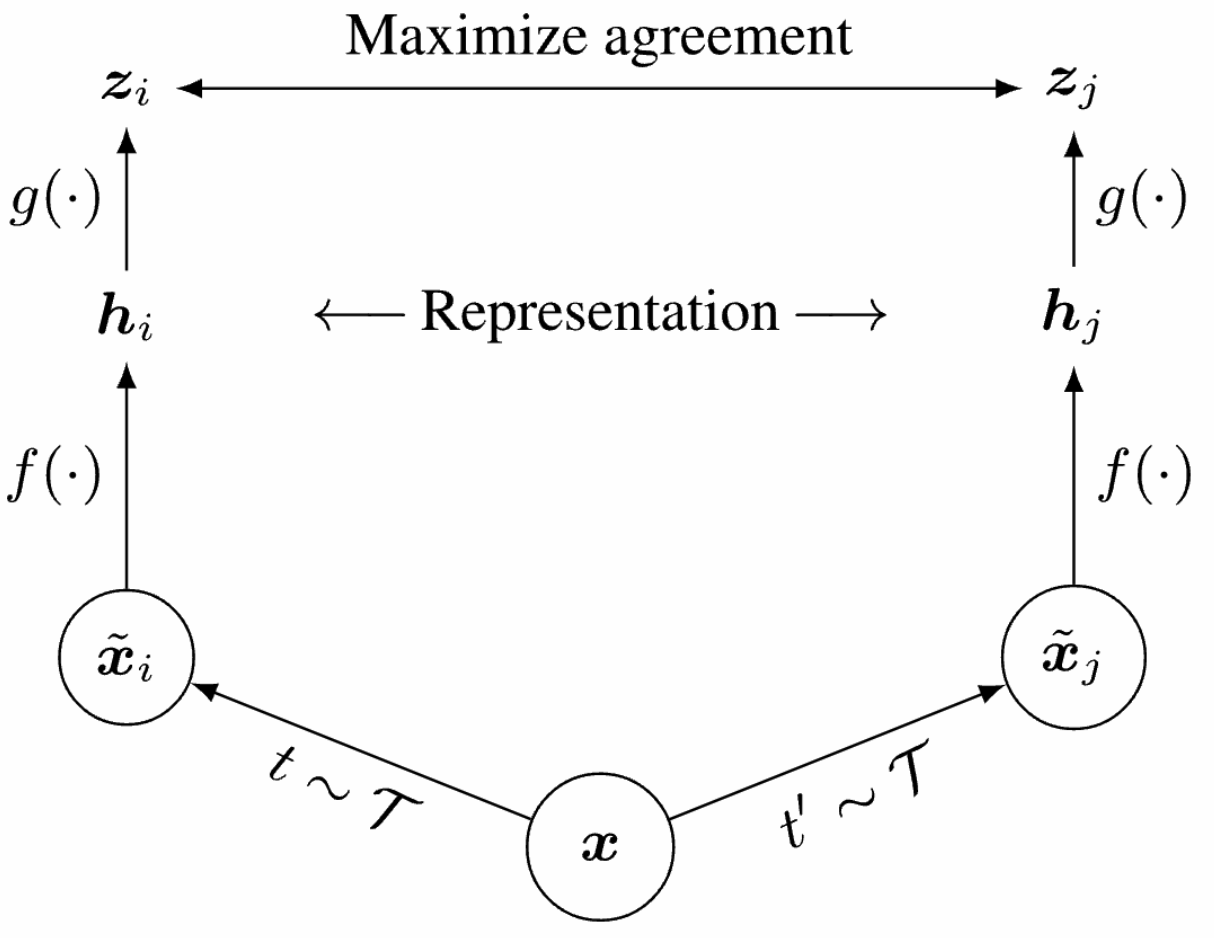

in which xi and xj are the two augmented version of x, f is the encoder BasModel, a CNN, which take in input x and produce the latent representation h, and g is a MLP (Projection Head) that starting from h produce the vector representation z in which we apply the contrastive loss.

The contrastive lossused by SimCLR is the popular Noise Contrastive Estimator (NCE) loss:

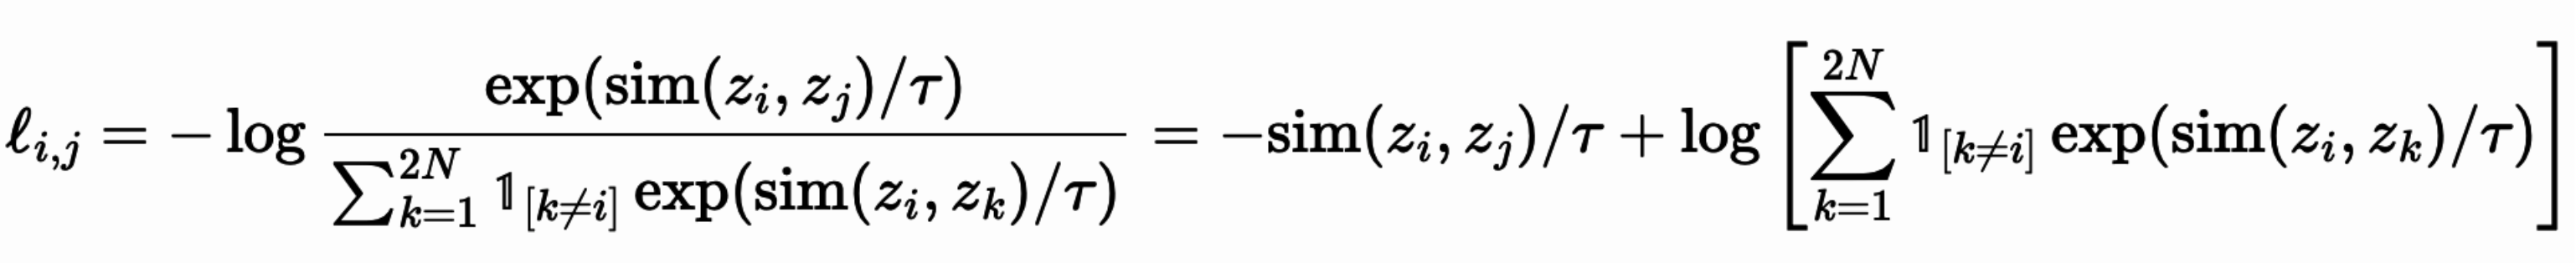

a modified form of the cross entropy loss ([A.V.D.Oord, Y.Li, and O.Vinyals: Representation learning with contrastive predictive coding, arXiv:1807.03748 (2018)](https://arxiv.org/abs/1807.03748)) , in which (zi,zj) is a positive pair, (zi,zk) a negative pair. The function sim si the similarity metric, the cosine similarity in the case of simCLR.

Stefano Giagu - v1.0 - 15.3.2022

**Read dataset and preporcess it**

data shape:  (20000, 32, 32)
(20000,)


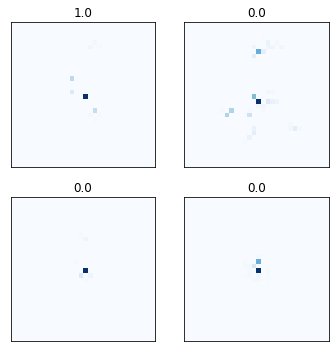

In [1]:
# jet images, 32x32 pixels (eta, phi) plane, with energy deposit on each calorimetric cell
# targets: binary label 0, 1, nornmal and merged jet

import numpy as np

with np.load('simCLR_dataset.npz') as f:
    train_features = f['train_features']
    train_targets = f['train_targets']

print("data shape: ",train_features.shape)
print(train_targets.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  ax.imshow(train_features[i], cmap='Blues')
  ax.set_title(train_targets[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()

## Data is not similar to "real natural images " Check the distribution of values!


maximun value :  399.883


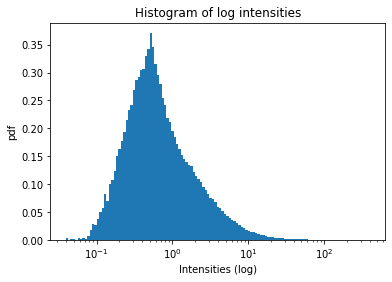

In [2]:
n_bin = 128
print("maximun value : ",np.max(train_features))
logbins = np.geomspace(train_features[train_features>0].min(), train_features.max(), n_bin)
plt.figure(111)
plt.hist(train_features.ravel(), bins=logbins,density=True)
plt.xscale('log')
plt.ylabel("pdf")
plt.xlabel("Intensities (log)")
plt.title("Histogram of log intensities")
plt.show()

## To visualize the rich structure of the data is better to show the logbins

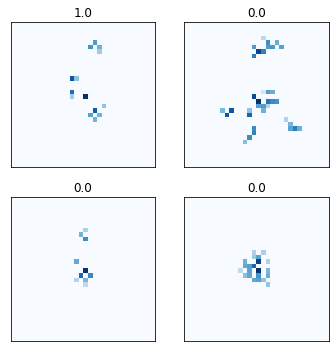

In [3]:


plt.figure(figsize=(5,5))
for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  ax.imshow(np.digitize(train_features[i],logbins)/n_bin, cmap='Blues')
  ax.set_title(train_targets[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()

In [4]:
# some useful libs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.10.2+cu102
0.11.3+cu102


In [5]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



In [6]:
# preprocess data: split on training, validation, test
# normalize fatures (pixels) in [0,1]

from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()


# training, validation, test split
from sklearn.model_selection import train_test_split
testset_frac = 0.2 # test set fraction wrt whole samples
valiset_frac = 0.25 # validation set fraction wrt training+validation

X_train,X_test,Y_train,Y_test = train_test_split(train_features,train_targets,test_size=testset_frac, shuffle=True, random_state=1234)
X_train,X_vali,Y_train,Y_vali = train_test_split(X_train,Y_train,test_size=valiset_frac, shuffle=True, random_state=1234)

X_train = X_train.reshape(X_train.shape[0],32*32)
X_vali = X_vali.reshape(X_vali.shape[0],32*32)
X_test = X_test.reshape(X_test.shape[0],32*32)


scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_vali = scaler.transform(X_vali)
X_test = scaler.transform(X_test)

    
X_train = X_train.reshape(X_train.shape[0],32,32)
X_vali = X_vali.reshape(X_vali.shape[0],32,32)
X_test = X_test.reshape(X_test.shape[0],32,32)

X_train = np.expand_dims(X_train, -1)
X_vali = np.expand_dims(X_vali, -1)
X_test = np.expand_dims(X_test, -1)

print('X_train shape: ',X_train.shape)
print('Y_train shape: ',Y_train.shape)
print('X_vali shape: ',X_vali.shape)
print('Y_vali shape: ',Y_vali.shape)
print('X_test shape: ',X_test.shape)
print('Y_test shape: ',Y_test.shape)

X_train shape:  (12000, 32, 32, 1)
Y_train shape:  (12000,)
X_vali shape:  (4000, 32, 32, 1)
Y_vali shape:  (4000,)
X_test shape:  (4000, 32, 32, 1)
Y_test shape:  (4000,)


## Visualize the training set after the normalization

X_train max:  1.0
X_train min:  0.0


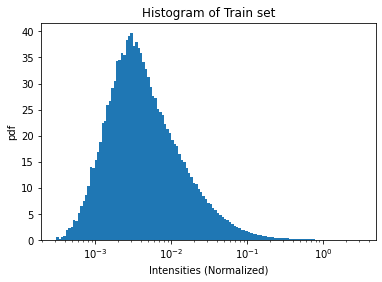

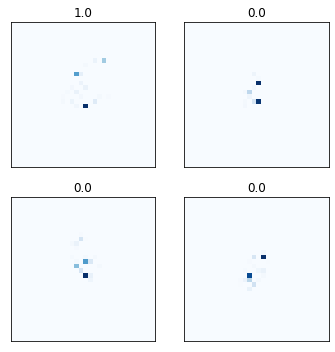

In [7]:
print('X_train max: ',X_train.max())
print('X_train min: ',X_train.min())

plt.figure(111)
plt.hist(X_train.ravel(),logbins/n_bin,density=True)

plt.ylabel("pdf")
plt.xlabel("Intensities (Normalized)")
plt.xscale('log')
plt.title("Histogram of Train set")
plt.show()

plt.figure(figsize=(5,5))
for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  ax.imshow(X_train[i], cmap='Blues')
  ax.set_title(train_targets[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()

In [8]:
# transform numpy vectors to pytorch tensors
X_train_pt = torch.Tensor(X_train)
Y_train_pt = torch.Tensor(Y_train)
X_vali_pt = torch.Tensor(X_vali)
Y_vali_pt = torch.Tensor(Y_vali)
X_test_pt = torch.Tensor(X_test)
Y_test_pt = torch.Tensor(Y_test)

# switch channel dimension position as needed by pytorch (NOTE: in numpy/keras (dim1,dim2,..., channels) in pytorch (channel, dim1, dim2, ...))
X_train_pt = X_train_pt.permute(0,3,1,2)
X_vali_pt = X_vali_pt.permute(0,3,1,2)
X_test_pt = X_test_pt.permute(0,3,1,2)

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_vali_pt.shape)
print(Y_vali_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([12000, 1, 32, 32])
torch.Size([12000])
torch.Size([4000, 1, 32, 32])
torch.Size([4000])
torch.Size([4000, 1, 32, 32])
torch.Size([4000])


**Let's first try a conventional supervised classification task with a CNN**



In [9]:
# CNN VGG-like model

from torch import nn
import torch.nn.functional as F

class VGGModel(nn.Module):
  def __init__(self):
    super(VGGModel, self).__init__()
  
    # first block
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3))
    
    # second block
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3))

    # tird block
    self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3))
    
    self.flatten = nn.Flatten()

    # MLP
    self.fc1 = nn.Linear(in_features=128, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=64)
    self.fc3 = nn.Linear(in_features=64, out_features=1)

    self.act = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=(2,2))
    self.act2 = nn.Sigmoid()

    self.drop = nn.Dropout(p=0.5)
    
  def forward(self, x):
    out = self.act(self.conv1(x))
    out = self.pool(out)
    out = self.act(self.conv2(out))
    out = self.pool(out)
    out = self.act(self.conv3(out))

    #flatten
    out = self.flatten(out)

    out = self.drop(out)
    out = self.act(self.fc1(out))
    out = self.drop(out)
    out = self.act(self.fc2(out))
    out = self.act2(self.fc3(out))
    
    return out

In [10]:
model = VGGModel()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,32,32))
else:
  summary(model, input_size=(1,32,32))

VGGModel(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (act): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (act2): Sigmoid()
  (drop): Dropout(p=0.5, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]              80
              ReLU-2            [-1, 8, 30, 30]               0
         MaxPool2d-3            [-1, 8, 15, 15]               0
            Conv2d-4            [-1, 8, 13, 13]             584
              ReLU-5         

In [11]:
#loss 
loss_func = nn.BCELoss() #binary cross entropy loss

#metric accuracy
def accuracy(out, yb):
    preds = out.cpu().reshape(-1).detach().numpy().round()
    return (preds == yb.cpu().detach().numpy()).mean()

metric_func = accuracy

# optim
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-3)

# scheduler for step decay lr schedule
#scheduler = optim.lr_scheduler.StepLR(opt, 10, gamma=0.1, last_epoch=-1, verbose=True)

In [12]:
# move the model into the GPU
model.to('cpu')
print('The model is in the: ', next(model.parameters()).device)
model.to(device)
print('now the model is in the: ', next(model.parameters()).device)

The model is in the:  cpu
now the model is in the:  cpu


In [13]:
#Checkpoints (to save model parameters during training)
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pth')

In [14]:
# training parameters

epochs = 200
batch_size = 64

# define dataloaders
from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt) 
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) 

dataset_vali = TensorDataset(X_vali_pt, Y_vali_pt) 
dataloader_vali = DataLoader(dataset_vali, batch_size=batch_size*4) 

In [15]:
#training loop

import time

save_best_model = SaveBestModel()

# lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

#loop over epochs
for epoch in range(epochs):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for xb, yb in dataloader_train: #takes a batch from the train dataloader 
        counter += 1 
        xb=xb.type(torch.float).to(device) #move troch tensors to device (cpu or GPU)
        yb=yb.type(torch.float).to(device)
        
        pred = model(xb) #get prediction for batch
        loss = loss_func(pred, torch.unsqueeze(yb,1)) #compute loss
        metric = metric_func(pred, yb) #compute metric

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric

        # backpropagation
        loss.backward()
        # update weights
        opt.step()
        # set to zero gradients for the next step
        opt.zero_grad()
 
    # normalize loss and metric by number of batches
    train_loss = train_loss/counter
    train_metric = train_metric/counter

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)


    # evaluation setp (same as trainign but w/o backpropagation)
    model.eval()

    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in dataloader_vali:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.float).to(device)
        pred = model(xb)
        vloss = loss_func(pred, torch.unsqueeze(yb,1))
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()
        
    vali_loss = vali_loss/counter
    vali_metric = vali_metric/counter    

    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    #save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)   

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

    # update learning rate schedule
    #scheduler.step()


Best validation loss: 0.47886145673692226

Saving best model for epoch: 1

epoch: 1, time(s): 1.9539, train loss: 0.651917, train metric: 0.591589, vali loss: 0.478861, vali metric: 0.782617

Best validation loss: 0.398820610716939

Saving best model for epoch: 2

epoch: 2, time(s): 1.6727, train loss: 0.471613, train metric: 0.794465, vali loss: 0.398821, vali metric: 0.830176

Best validation loss: 0.3954639360308647

Saving best model for epoch: 3

epoch: 3, time(s): 2.0480, train loss: 0.437640, train metric: 0.812749, vali loss: 0.395464, vali metric: 0.834473

Best validation loss: 0.38785940781235695

Saving best model for epoch: 4

epoch: 4, time(s): 1.6083, train loss: 0.422825, train metric: 0.820312, vali loss: 0.387859, vali metric: 0.835254

Best validation loss: 0.3786233011633158

Saving best model for epoch: 5

epoch: 5, time(s): 1.5582, train loss: 0.414469, train metric: 0.823720, vali loss: 0.378623, vali metric: 0.839941

Best validation loss: 0.37247628159821033



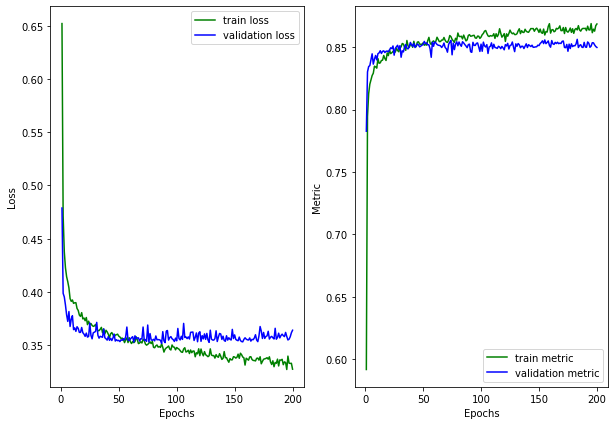

In [16]:
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

# SimCLR

First part delas with the dataset creation and data augmentation. We'll do that by creating a torch Dataset custom class and a custom transformation function that will apply a torch transofrmation set to the input image and produce in output two augmented version of each image.

In [17]:
import torchvision
from torchvision import transforms, utils

# custom class that takes an image and outputs n_views random ransformation according to the 
# base_transforms list 
class ContrastiveTransformations(object):
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [18]:
# Data-augmentation transformations
# compose 4 different transformations from the trochvision lib: random horizontal pixels flip, random vertical pixels flip, random rotation, and random crop of the image

contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomRotation(180.),
                                          transforms.RandomResizedCrop(size=32),
                                         ])

In [19]:
from operator import indexOf
# create a custom dataset
from torch.utils.data import Dataset, DataLoader

class JetSubStructure(Dataset):
    """JetSubstructure dataset."""

    def __init__(self, data, labels, phase='train', transform=None):
        """
        Args:
            data: torch tensor containing images
            labels: torch tensor containing associated label
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.phase = phase
        self.data = data
        self.label = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        label = self.label[idx]

        if self.transform:
          if self.phase == 'train':
            sample = self.transform(sample)
          else: 
            sample = [sample, sample]

        
        return sample, label

In [20]:
# create the dataset
dataset_img = JetSubStructure(data=X_train_pt, labels=Y_train_pt, phase='train', transform=ContrastiveTransformations( base_transforms=contrast_transforms, n_views=2))
dataset_img_v = JetSubStructure(data=X_vali_pt, labels=Y_vali_pt, phase='vali', transform=ContrastiveTransformations( base_transforms=contrast_transforms, n_views=2))

In [21]:
# print one element of the dataset
for i in range(len(dataset_img)):
  images, label = dataset_img[i]
  print(images[0].shape, images[1].shape)
  print(label.shape)
  break

torch.Size([1, 32, 32]) torch.Size([1, 32, 32])
torch.Size([])


In [22]:
# create the dataloaders (make sure to drop images that do not cope with the batch_size=128 requirement)
batch_size = 128
dataloader_img = DataLoader(dataset_img, batch_size=batch_size, shuffle=True, drop_last=True) 
dataloader_img_v = DataLoader(dataset_img_v, batch_size=batch_size, shuffle=True, drop_last=True)

In [23]:
# test it
x1,x2 = next(iter(dataloader_img))
print(x1[0].shape, x1[1].shape, x2.shape )

torch.Size([128, 1, 32, 32]) torch.Size([128, 1, 32, 32]) torch.Size([128])


In [24]:
# SimCLR Model

# three parts:

# BaseModel: same VGG as in the supervised case but w/o sigmoid output layer
# Projection Head: a simple MLP
# SimCLR: a composition of the two previous blocks

from torch import nn
import torch.nn.functional as F

class VGGBaseModel(nn.Module):
  def __init__(self):
    super(VGGBaseModel, self).__init__()
  
    # first block
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3))
  
    # second block
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3))

    # tird block
    self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3))
    
    self.flatten = nn.Flatten()

    # MLP
    self.fc1 = nn.Linear(in_features=128, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=64)

    self.act = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=(2,2))
    self.act2 = nn.Sigmoid()

    self.drop = nn.Dropout(p=0.5)
    
  def forward(self, x):
    out = self.act(self.conv1(x))
    out = self.pool(out)
    out = self.act(self.conv2(out))
    out = self.pool(out)
    out = self.act(self.conv3(out))  

    #flatten
    out = self.flatten(out)

    out = self.drop(out)
    out = self.act(self.fc1(out))
    out = self.drop(out)
    out = self.act(self.fc2(out))

    return out

In [25]:
class ProjectionHead(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               out_features, **kwargs):
    super(ProjectionHead, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.hidden_features = hidden_features

    self.layers = nn.Sequential(
      nn.Linear(self.in_features, self.hidden_features, bias=True),
      nn.BatchNorm1d(self.hidden_features),
      nn.ReLU(),
      nn.Linear(self.hidden_features, self.out_features, bias=False),
      nn.BatchNorm1d(self.out_features)
    )

  def forward(self,x):
    out = self.layers(x)
    return out

In [26]:
class SimCLRModel(nn.Module):
  def __init__(self, base_model, proj_head):
    super(SimCLRModel, self).__init__()
    self.base_model = base_model
    self.proj_head = proj_head

  def forward(self,x):
    out = self.base_model(x)
    out = self.proj_head(out) 
    return out

In [27]:
# instantiate the model
model = SimCLRModel(VGGBaseModel(), ProjectionHead(64, 2048, 128))
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,32,32))
else:
  summary(model, input_size=(1,32,32))

SimCLRModel(
  (base_model): VGGBaseModel(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (act): ReLU()
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (act2): Sigmoid()
    (drop): Dropout(p=0.5, inplace=False)
  )
  (proj_head): ProjectionHead(
    (layers): Sequential(
      (0): Linear(in_features=64, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=128, bias=False)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)
----------------

In [28]:
model = model.to(device)

In [29]:
# NCELoss function
# from https://github.com/Spijkervet/SimCLR implementation

class NCELoss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(NCELoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

In [30]:
# LARS optmizers (optimizer procedure designed for large mini-batch training)
# Y. You, I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)

# implementation code from https://github.com/Spijkervet/SimCLR

from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

In [31]:
#OPTMIZER
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
#SCHEDULER OR LINEAR EWARMUP
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)

#SCHEDULER FOR COSINE DECAY
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

#LOSS FUNCTION
criterion = NCELoss(batch_size = 128, temperature = 0.5)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch     0: adjusting learning rate of group 0 to 2.0000e-01.


In [32]:
# utulity function to plot during training the quality of the learned representation
# plots tSNE 2D distributions of learned representation
# for tSNE: see https://scikit-learn.org/stable/modules/manifold.html#t-sne

from sklearn.manifold import TSNE

def plot_features(model, num_classes, num_feats, batch_size, val_df = None):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    labs = np.array([])
    model.eval()
    with torch.no_grad():
        for img, lab in dataloader_img_v:
            x1 = img[0]
            x1 = x1.to(device = device, dtype = torch.float)
            out = model(x1)
            out = out.cpu().data.numpy()
            feats = np.append(feats,out,axis = 0)
            labs = np.append(labs,lab,axis = 0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    num_samples = len(dataloader_img_v)

    for i in range(num_classes):
        plt.scatter(x_feats[labs==i,1],x_feats[labs==i,0])
    
    plt.legend([str(i) for i in range(num_classes)])
    plt.show()

In [ ]:
plot_features(model, 2, 128, 128)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
device

In [ ]:
# Train and Validation function

def train(train_loader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, (img, lab) in enumerate(train_loader):
        optimizer.zero_grad()
        x_i = img[0]
        x_j = img[1]
        x_i = x_i.to(device).float()
        x_j = x_j.to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)
        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch

def valid(valid_loader, model, criterion):
    loss_epoch = 0
    for step, (img, lab) in enumerate(valid_loader):
        x_i = img[0]
        x_j = img[1]
        x_i = x_i.to(device).float()
        x_j = x_j.to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        
        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(valid_loader)}]\t Loss: {round(loss.item(),5)}")

        loss_epoch += loss.item()
    return loss_epoch

In [ ]:
# Train loop

tr_loss = []
val_loss = []

nr = 0
global_step = 0
current_epoch = 0

for epoch in range(100):
        
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    tr_loss_epoch = train(dataloader_img, model, criterion, optimizer)

    if nr == 0 and epoch < 10:
        warmupscheduler.step()
    if nr == 0 and epoch >= 10:
        mainscheduler.step()
    
    lr = optimizer.param_groups[0]["lr"]

    model.eval()
    with torch.no_grad():
        val_loss_epoch = valid(dataloader_img_v, model, criterion)

    if nr == 0:
        
        tr_loss.append(tr_loss_epoch / len(dataloader_img))
        
        val_loss.append(val_loss_epoch / len(dataloader_img_v))
        
        print(
            f"Epoch [{epoch}/{epochs}]\t Training Loss: {tr_loss_epoch / len(dataloader_img)}\t lr: {round(lr, 5)}"
        )
        print(
            f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(dataloader_img_v)}\t lr: {round(lr, 5)}"
        )
        current_epoch += 1

    time_taken = (time.time()-stime)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")

    if (epoch+1)%10==0:
        plot_features(model, 2, 128, 128)

## To do##


1.   play with the code, understand it, play with hyperparameters (mini-batch size). It is not optmized for the specific task.
2.   save the trained model and test it by evaluating the quality of the representations learned using a linear evaluation protocol: a logistic regression model:


```
- take the training data and pass it through the pre-trained SimCLR model and store the output representations from the f() model (CNN)
- use these fixed representations to train a Logistic Regression model using the training labels as targets
- the testing accuracy is a measure of the feature quality
- compare with the feature extracted from the first model trained with a supervised protocol

NOTE: since the base network 𝑓(⋅) is not changed during the training process of the
logistic regression, the model can only perform well if the representations of h describe all features that might be necessary for the task
```

